In [1]:
import pandas as pd
import numpy as np
import json
from scipy import stats

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 99)

In [3]:
# Read in results data for control and treatment for 6 boxes experiment
df = pd.read_csv("../data/6_boxes/6_Boxes_2qns_0Motvs.csv")
df['Treat'] = 0
df_treat = pd.read_csv("../data/6_boxes/6_Boxes_2qns_3Motvs.csv")
df_treat['Treat'] = 1
df = df.append(df_treat)
df = df.drop(columns=['HITId', 'HITTypeId', 'AssignmentId', 'AcceptTime', 'SubmitTime', 'Title', 'Description', 'Keywords', 'Reward', 'CreationTime',
                      'MaxAssignments', 'RequesterAnnotation', 'AssignmentDurationInSeconds',
                      'AutoApprovalDelayInSeconds', 'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
                      'AssignmentStatus', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime', 'RequesterFeedback',
                      'LifetimeApprovalRate', 'Last30DaysApprovalRate', 'Last7DaysApprovalRate',
                      'Answer.annotatedResult.inputImageProperties.height', 'Answer.annotatedResult.inputImageProperties.width',
                      'Approve', 'Reject'])
df.columns = ['WorkerId', 'TimeInSeconds',
              '1.cellphone', '1.tablet', '1.smalllaptop', '1.midsize', '1.largescreen', '1.notsure',
              '2.mouse', '2.trackpad', '2.touchscreen', '2.other', 'BoundingBoxes', 'Treat']

# Read in ground truth for 6 boxes
df_gt = pd.read_csv("../data/6_boxes/6_boxes_ground_truth.csv")

In [4]:
# Clean up survey data columns

def fx(col1='False', col2='False', col3='False', col4='False', col5='False', col6='False'):
    val = 0
    if col1 == True:
        val = 1
    elif col2 == True:
        val = 2
    elif col3 == True:
        val = 3
    elif col4 == True:
        val = 4
    elif col5 == True:
        val = 5
    elif col6 == True:
        val = 6
        
    return val

df['Survey_Q1'] = np.vectorize(fx)(df['1.cellphone'], df['1.tablet'], df['1.smalllaptop'], df['1.midsize'],
                                   df['1.largescreen'], df['1.notsure'])
df['Survey_Q2'] = np.vectorize(fx)(df['2.mouse'], df['2.trackpad'], df['2.touchscreen'], df['2.other'])
df = df.drop(columns=['1.cellphone', '1.tablet', '1.smalllaptop', '1.midsize', '1.largescreen', '1.notsure'])
df = df.drop(columns=['2.mouse', '2.trackpad', '2.touchscreen', '2.other'])

df.head()

,WorkerId,TimeInSeconds,BoundingBoxes,Treat,Survey_Q1,Survey_Q2
0,AEIA157NS3EK0,175,"[{""height"":411,""label"":""Car 1"",""left"":133,""top...",0,4,1
1,AKAXNPN3073EJ,358,"[{""height"":381,""label"":""Car 1"",""left"":153,""top...",0,4,2
2,AM865HGI72GRZ,120,"[{""height"":395,""label"":""Car 1"",""left"":130,""top...",0,5,1
3,AKV2CSK35JW0D,731,"[{""height"":407,""label"":""Car 4"",""left"":135,""top...",0,2,3
4,A3FA5P7O80KJAP,712,"[{""height"":388,""label"":""Car 1"",""left"":129,""top...",0,4,3


In [5]:
# Return ground truth for specified label

def find_gt(df_gt, label):
    val = ""
    for i in range(len(df_gt)):
        if df_gt.iloc[i]['gt_label'] == label:
            val = df_gt.iloc[i]
    return val

In [6]:
# Break out each bb for each image into a separate row, add ground truth to each row

df2 = pd.DataFrame()

for i in range(len(df)):
    bb_data = json.loads(df.iloc[i]['BoundingBoxes'])
    row = df.iloc[i]
    for j in range(len(bb_data)):
        bb = pd.Series(bb_data[j])
        row1 = row.append(bb)
        row1 = row1.append(pd.Series(find_gt(df_gt, bb['label'])))
        df2 = df2.append(row1, ignore_index=True)


In [37]:
# top = as.integer(bounding_box$top)
# left = as.integer(bounding_box$left)
# bottom = as.integer(top + bounding_box$height)
# right = as.integer(left + bounding_box$width)

# Euclidean distance accuracy
def area_calc(height, width):
    return height * width

# Euclidean distance accuracy
def score_calc(gt_top, top, gt_right, right, gt_bottom, bottom, gt_left, left):
    return np.sqrt(np.power(gt_top - top, 2) + np.power(gt_right - right, 2)) + \
           np.sqrt(np.power(gt_bottom - bottom, 2) + np.power(gt_left - left, 2))

# Intersection over Union Accuracy
def iou_calc(gt_top, top, gt_right, right,
             gt_bottom, bottom, gt_left, left,
             gt_width, width, gt_height, height):
  # Determine the coordinates of each of the two boxes
  xA = max(gt_left, left)
  yA = max(gt_top, top)
  xB = min(gt_right, right)
  yB = min(gt_bottom, bottom)
    
  # Calculate the area of the intersection area
  area_of_intersection = (xB - xA + 1) * (yB - yA + 1)
 
  # Calculate the area of both rectangles
  box_a_area = (gt_width + 1) * (gt_height + 1)
  box_b_area = (width + 1) * (height + 1)
  # Calculate the area of intersection divided by the area of union
  # Area of union = sum both areas less the area of intersection
  iou = area_of_intersection / float(box_a_area + box_b_area - area_of_intersection)
 
  # Return the score

  # check for non-overlapping rectangles
  if ((gt_left > right) or (gt_right < left) or
      (gt_bottom < top) or (gt_top > bottom)):
    return -999
  else:
    return iou

# calculate euclidean score

df2['bottom'] = df2['top'] + df2['height']
df2['right'] = df2['left'] + df2['width']
df2['gt_area'] = df2['gt_height'] * df2['gt_width']
df2['area'] = df2['height'] * df2['width']
df2['euclidean_score'] = np.vectorize(score_calc)(df2['gt_top'], df2['top'],
                                                  df2['gt_right'], df2['right'],
                                                  df2['gt_bottom'], df2['bottom'],
                                                  df2['gt_left'], df2['left'])



In [38]:
# calculate intersection over union score

df2['iou_score'] = np.vectorize(iou_calc)(df2['gt_top'], df2['top'],
                                          df2['gt_right'], df2['right'],
                                          df2['gt_bottom'], df2['bottom'],
                                          df2['gt_left'], df2['left'],
                                          df2['gt_width'], df2['width'],
                                          df2['gt_height'], df2['height'])
column_order = ['WorkerId', 'Treat', 'TimeInSeconds', 'Survey_Q1', 'Survey_Q2', 'BoundingBoxes',
                'gt_label', 'gt_bottom', 'gt_top', 'gt_left', 'gt_right', 'gt_height', 'gt_width',
                'label', 'bottom', 'top', 'left', 'right', 'height', 'width', 'gt_area', 'area',
                'euclidean_score', 'iou_score']
df2 = df2[column_order] 
df2.head()

,WorkerId,Treat,TimeInSeconds,Survey_Q1,Survey_Q2,BoundingBoxes,gt_label,gt_bottom,gt_top,gt_left,gt_right,gt_height,gt_width,label,bottom,top,left,right,height,width,gt_area,area,euclidean_score,iou_score
0,AEIA157NS3EK0,0.0,175.0,4.0,1.0,"[{""height"":411,""label"":""Car 1"",""left"":133,""top...",Car 1,538.0,127.0,122.0,952.0,411.0,830.0,Car 1,549.0,138.0,133.0,964.0,411.0,831.0,341130.0,341541.0,31.835170,0.922781
1,AEIA157NS3EK0,0.0,175.0,4.0,1.0,"[{""height"":411,""label"":""Car 1"",""left"":133,""top...",Car 2,617.0,268.0,1472.0,2086.0,349.0,614.0,Car 2,627.0,256.0,1481.0,2098.0,371.0,617.0,214286.0,228907.0,30.424187,0.910121
2,AEIA157NS3EK0,0.0,175.0,4.0,1.0,"[{""height"":411,""label"":""Car 1"",""left"":133,""top...",Car 3,614.0,262.0,2447.0,3126.0,352.0,679.0,Car 3,622.0,256.0,2427.0,3136.0,366.0,709.0,239008.0,259494.0,33.202563,0.921211
3,AEIA157NS3EK0,0.0,175.0,4.0,1.0,"[{""height"":411,""label"":""Car 1"",""left"":133,""top...",Car 4,1493.0,1110.0,294.0,1043.0,383.0,749.0,Car 4,1499.0,1147.0,288.0,1051.0,352.0,763.0,286867.0,268576.0,46.340268,0.874960
4,AEIA157NS3EK0,0.0,175.0,4.0,1.0,"[{""height"":411,""label"":""Car 1"",""left"":133,""top...",Car 5,1463.0,1144.0,1460.0,2111.0,319.0,651.0,Car 5,1476.0,1138.0,1455.0,2109.0,338.0,654.0,207669.0,221052.0,20.252944,0.934055


In [39]:
df2.groupby('Treat').agg({"euclidean_score": [min, max, 'mean', 'std']})

euclidean_score                                     
                  min          max        mean         std
Treat                                                     
0.0               1.0  4846.312998  192.094013  629.411890
1.0               1.0  4680.037835  132.492396  452.264907

In [45]:
df2[df2['iou_score'] > 0.1].groupby('Treat').agg({"euclidean_score": [min, max, 'mean', 'std']})

euclidean_score                                  
                  min         max       mean        std
Treat                                                  
0.0               1.0  798.876741  37.706362  50.597350
1.0               1.0  749.585074  35.767077  55.251791

In [40]:
df2.groupby('Treat').agg({"iou_score": [min, max, 'mean', 'std']})

iou_score                                 
            min       max       mean         std
Treat                                           
0.0      -999.0  0.998377 -54.513631  228.803925
1.0      -999.0  0.998529 -34.940682  185.888423

In [44]:
df2[df2['iou_score'] > 0.1].groupby('Treat').agg({"iou_score": [min, max, 'mean', 'std']})

iou_score                              
            min       max      mean       std
Treat                                        
0.0    0.103619  0.998377  0.912685  0.082069
1.0    0.127166  0.998529  0.916847  0.098127

In [43]:
# write out new score file

df2.to_csv("../data/6_boxes/6_Boxes_Score_File.csv", index=False)

In [54]:
dfx = df2[df2['iou_score'] > 0.1]
t_test_euclidean = stats.ttest_ind(dfx[dfx['Treat']==0]['euclidean_score'],dfx[dfx['Treat']==1]['euclidean_score'])
print(f"Euclidean score: {t_test_euclidean}")

t_test_iou = stats.ttest_ind(dfx[dfx['Treat']==0]['iou_score'],dfx[dfx['Treat']==1]['iou_score'])
print(f"IOU score: {t_test_iou}")

Euclidean score: Ttest_indResult(statistic=1.2082307350119306, pvalue=0.22702384050534066)
IOU score: Ttest_indResult(statistic=-1.5161771195921314, pvalue=0.12954683410839218)


In [59]:
print(f"Overall average number of responses per MTurker: {round(len(df2) / len(df),2)}")
print(f"Control average number of responses per MTurker: {round(len(df2[df2['Treat'] == 0]) / len(df[df['Treat'] == 0]),2)}")
print(f"Treatment average number of responses per MTurker: {round(len(df2[df2['Treat'] == 1]) / len(df[df['Treat'] == 1]),2)}")

Overall average number of responses per MTurker: 5.86
Control average number of responses per MTurker: 5.69
Treatment average number of responses per MTurker: 6.04


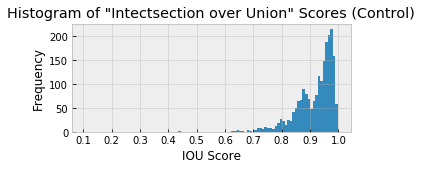

In [114]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick

plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 2))
axes.set_xlabel('IOU Score')
axes.set_ylabel('Number of HITs')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axes = dfx[dfx['Treat'] == 0]['iou_score'].plot(kind='hist',
                                                title='Histogram of "Intectsection over Union" Scores (Control)',
                                                bins=100)

#dfx[dfx['Treat'] == 0].hist(column='iou_score', bins=100, ax=axes)
pass

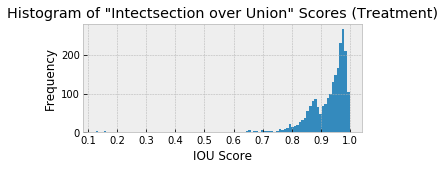

In [116]:
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 2))
axes.set_xlabel('IOU Score')
axes.set_ylabel('Number of HITs')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axes = dfx[dfx['Treat'] == 1]['iou_score'].plot(kind='hist',
                                                title='Histogram of "Intectsection over Union" Scores (Treatment)',
                                                bins=100)

#dfx[dfx['Treat'] == 1].hist(column='iou_score', bins=100, ax=axes)
pass

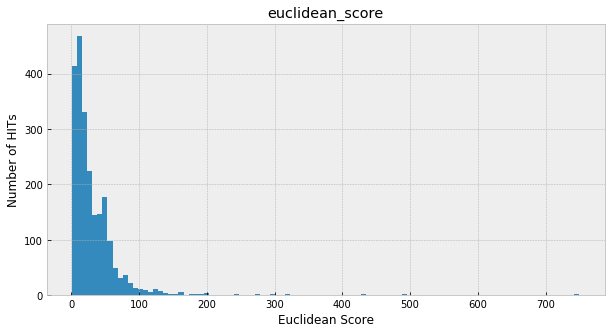

In [85]:
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.set_xlabel('Euclidean Score')
axes.set_ylabel('Number of HITs')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
dfx[dfx['Treat'] == 1].hist(column='euclidean_score', bins=100, ax=axes)
pass